### Import Libraries

In [1]:
# Import libraries
import os 
import sys
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Image
import IPython.display as ipd
from tqdm import tqdm, tqdm_pandas
import random

### Read in data

In [2]:
Train_pt_DIR = './train_pt'
Train_Metadata_DIR = './train_metadata.csv'
Scored_Bird_DIR ='./scored_birds.json'
Train_DIR = './train_audio/'
Audio_Rating_Dir = "./bird_audio_rating_mapping.pkl"

#read in metadata as df
train_df = pd.read_csv(Train_Metadata_DIR)
train_df.head()
train_df['dir'] = Train_DIR+train_df['filename']
tqdm.pandas()

In [3]:
def get_single_spectogram_from_file(bird_idx, row):
    #get only 1 spectogram based on the bird, and one particular row
    bird = idx2bird[bird_idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216) # to convert to N,C, H, W format
    #print(bird, row)
    x_train = x_train[row]
    x_train = x_train.view(-1,1,128,216)
    
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,bird_idx] = 1
    
    return x_train, y_train

In [4]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

Total number of birds 152


In [5]:
#for mapping of bird (str) to idx (int)
bird2idx = {}
for i, bird in enumerate(all_birds):
    bird2idx[bird] = i
    
idx2bird = {}
for _, (k, v) in enumerate(bird2idx.items()): 
    idx2bird[v] = k 

### Generate training data in .pt

In [6]:
def get_single_spec(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_spectogram = int(duration/chunk_duration)
    spectograms = []
    for i in range(num_spectogram):
        y, sr = librosa.load(filename, offset=i*chunk_duration, duration=chunk_duration)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)

    return S_DB

In [7]:
def spec_augment(spec, num_mask=2, 
                 freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):
    
    spec = spec.detach().clone()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

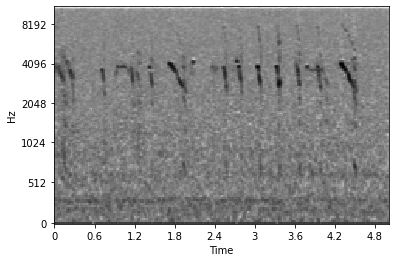

In [10]:
filename = './train_audio/arcter/XC535243.ogg'
spec = get_single_spec(filename)
librosa.display.specshow(spec, cmap='gray_r', sr=22050, x_axis='time', y_axis='mel');

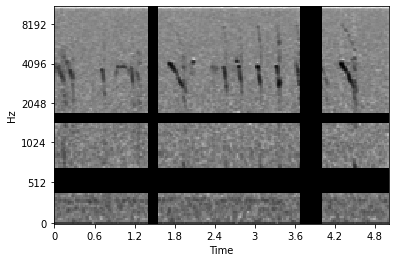

In [11]:
spec_new = spec_augment(torch.tensor(spec)).detach().numpy()
librosa.display.specshow(spec_new, cmap='gray_r', sr=22050, x_axis='time', y_axis='mel');